In [2]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)


gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

VER = 5

LOAD_MODELS_FROM = None

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

2024-05-10 18:49:47.319142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 18:49:47.319259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 18:49:47.457889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version = 2.15.0
Using 0 GPU


In [2]:

tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

Mixed precision enabled


# Loading Data

In [3]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
eeg_id_changes = df.groupby('eeg_id')['expert_consensus'].nunique()

changed_eeg_ids = eeg_id_changes[eeg_id_changes > 1].index
unchanged_eeg_ids = eeg_id_changes[eeg_id_changes == 1].index

In [5]:
len(changed_eeg_ids) + len(unchanged_eeg_ids) 

17089

# Additional Preprocessing with pandas



In [6]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [7]:
train_unchanged = train[train['eeg_id'].isin(unchanged_eeg_ids)]
train_changed = train[train['eeg_id'].isin(changed_eeg_ids)]

In [8]:
train = train_unchanged

# Read Train Spectrograms 


In [9]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 2.74 s, sys: 6.04 s, total: 8.78 s
Wall time: 1min 19s


# Read EEG Spectrograms


In [10]:
%%time
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 4.27 s, sys: 8.5 s, total: 12.8 s
Wall time: 1min 42s


# Train DataLoader



In [11]:
import albumentations as albu
import keras_cv

TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train',
                 specs = spectrograms, eeg_specs = all_eegs): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X,y = self.__augment_batch(X,y) 
        if self.mode != 'test':
            y = self.__apply_label_smoothing(y)
    
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),128,256,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,256),dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test': 
                r = 0
            else: 
                r = int( (row['min'] + row['max'])//4 )

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j,:,:,4:] = img
                
            if self.mode!='test':
                y[j,] = row[TARGETS]
            
        return X,y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
        ])
        return composition(image=img)['image']

            
    def __augment_batch(self, img_batch, y_batch):
        return img_batch, y_batch
    
    def __apply_label_smoothing(self, labels, factor=0.05):
        labels = labels * (1 - factor)
        labels = labels + (factor / 6)
    
        return labels


Using TensorFlow backend


# Display DataLoader
Below we display example dataloader spectrogram images.

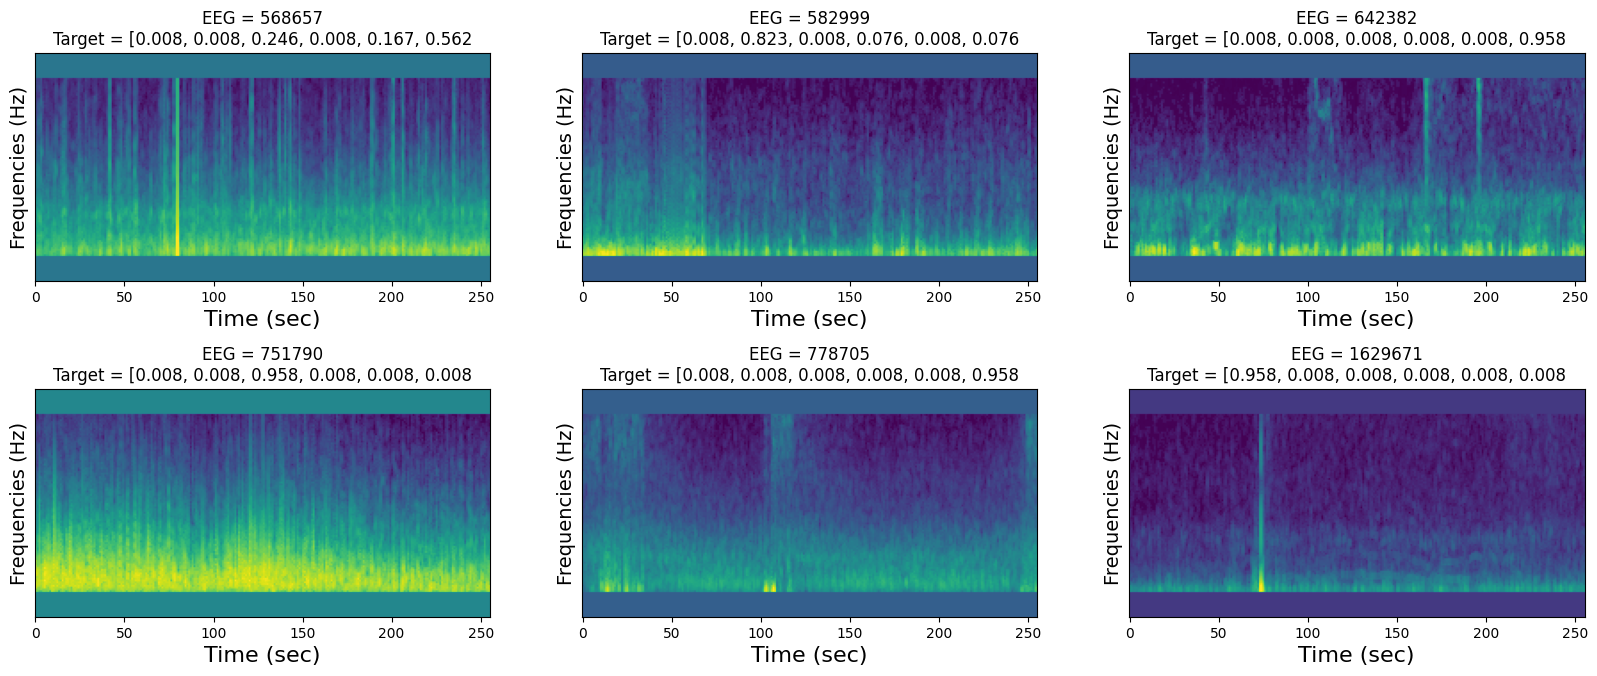

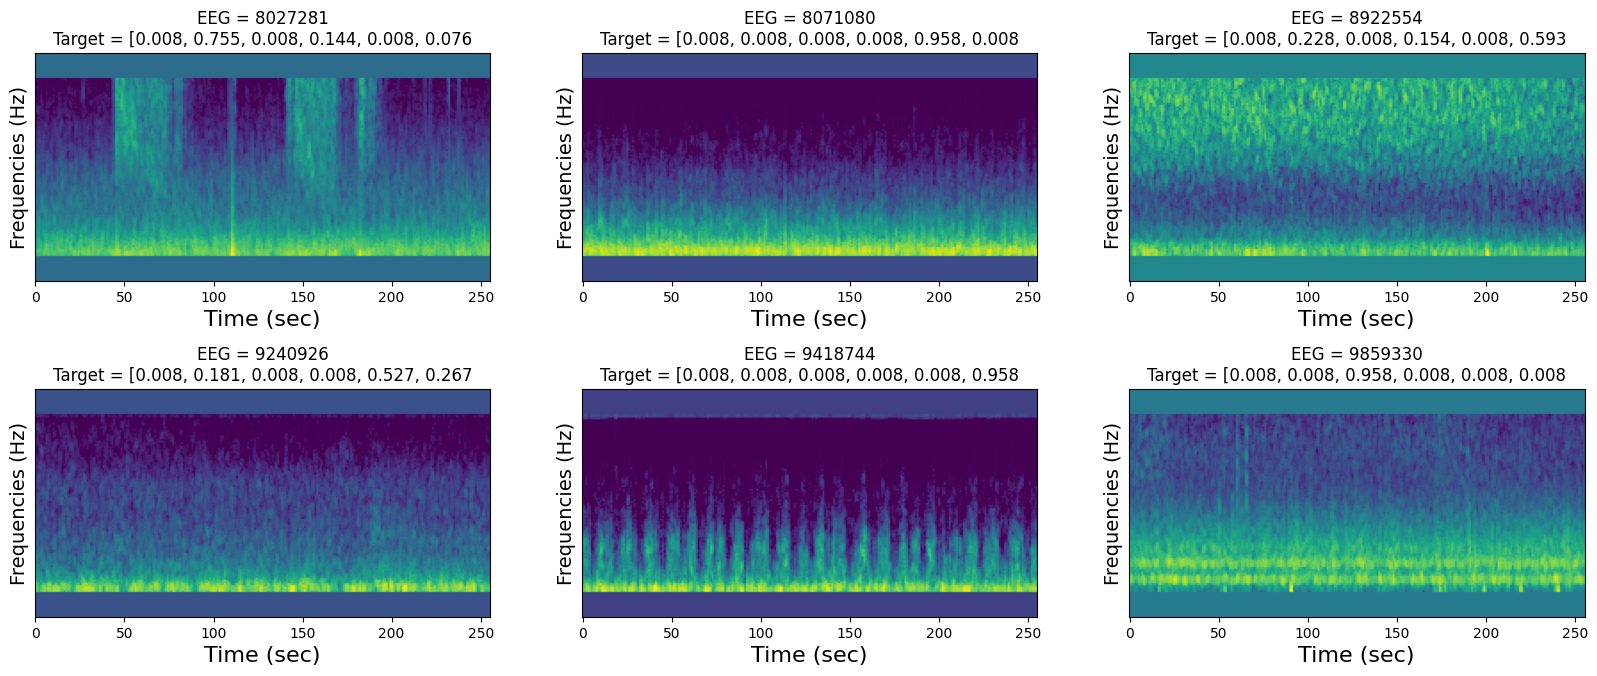

In [12]:
gen = DataGenerator(train, batch_size=32, shuffle=False)
ROWS=2; COLS=3; BATCHES=2

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0][::-1,]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.3f}'
            for s in t[1:]: tars += f', {s:0.3f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i==BATCHES-1: break

# Train Scheduler
We will train our model with a Step Train Schedule for 4 epochs. First 2 epochs are LR=1e-3. Then epochs 3 and 4 use LR=1e-4 and 1e-5 respectively. (Below we also provide a Cosine Train Schedule if you want to experiment with it. Note it is not used in this notebook).

In [3]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 10

def lrfn(epoch):
    return 1e-3
rng = [i for i in range(EPOCHS2)]
lr_y = [lrfn(x) for x in rng]

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [5]:
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 10

def lrfn(epoch):
    return 1e-3

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [16]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl (from efficientnet==1.1.1)



Writing the transformer block for the transformer to call later



In [17]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"), 
            tf.keras.layers.Dense(embed_dim)  # Ensure this matches embed_dim
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [19]:
import efficientnet.tfkeras as efn

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def build_model():
    inp = tf.keras.Input(shape=(128, 256, 8))
    x = layers.Conv2D(3, (1, 1), padding='same')(inp)

    base_model = efn.EfficientNetB0(include_top=False, input_shape=(128, 256, 3), weights=None)
    x = base_model(x)
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = layers.Reshape((1, -1))(x)

    # transformer
    transformer_block = TransformerBlock(embed_dim=1280, num_heads=4, ff_dim=512)  # Ensure embed_dim matches the output dim from GlobalAveragePooling
    transform_x = transformer_block(x)
    
    x = layers.Flatten()(transform_x)
    # dense layer 
    x = tf.keras.layers.Dense(6, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=inp, outputs=x)
    model.compile(optimizer='adam', loss='kl_divergence')

    return model

# Train Model
We train using Group KFold on patient id. If `LOAD_MODELS_FROM = None`, then we will train new models in this notebook version. Otherwise we will load saved models from the path `LOAD_MODELS_FROM`.

In [20]:
from sklearn.model_selection import GroupKFold,StratifiedGroupKFold
import tensorflow.keras.backend as K, gc
from tensorflow.keras.callbacks import EarlyStopping

all_oof = []
all_true = []

sgkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(sgkf.split(train, train.target, groups=train.patient_id)):  
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(train.iloc[train_index], shuffle=False, batch_size=32, augment=False)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    ES = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    if LOAD_MODELS_FROM is None:
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR,ES])
        model.save_weights(f'EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13044, valid size 3262
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2024-05-03 20:44:19.105911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1714769064.855642      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 [==============================] - 143s 247ms/step - loss: 2.4408 - val_loss: 1.1367 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
408/408 [==============================] - 98s 240ms/step - loss: 0.9751 - val_loss: 0.9454 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
408/408 [==============================] - 99s 242ms/step - loss: 0.7248 - val_loss: 0.7946 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
408/408 [==============================] - 96s 236ms/step - loss: 0.6110 - val_loss: 0.8517 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
408/408 [==============================] - 96s 236ms/step - loss: 0.5423 - val_loss: 0.7872 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
408/408 [==============================] - 88s 215ms/step - loss: 0.4771 - val_loss: 0.7426 - lr: 0

2024-05-03 20:58:20.239999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


408/408 [==============================] - 133s 245ms/step - loss: 3.4418 - val_loss: 1.2920 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
408/408 [==============================] - 100s 244ms/step - loss: 1.1394 - val_loss: 1.2238 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
408/408 [==============================] - 96s 235ms/step - loss: 1.1125 - val_loss: 1.1092 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
408/408 [==============================] - 96s 234ms/step - loss: 1.0967 - val_loss: 1.1225 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
408/408 [==============================] - 93s 228ms/step - loss: 1.0338 - val_loss: 1.1033 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
408/408 [==============================] - 96s 234ms/step - loss: 0.9642 - val_loss: 1.1322 - lr: 

2024-05-03 21:15:15.025114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


408/408 [==============================] - 133s 244ms/step - loss: 6.3349 - val_loss: 5.7624 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
408/408 [==============================] - 96s 235ms/step - loss: 4.4503 - val_loss: 1.1082 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
408/408 [==============================] - 95s 233ms/step - loss: 0.9858 - val_loss: 0.9915 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
408/408 [==============================] - 96s 234ms/step - loss: 0.7685 - val_loss: 0.8487 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
408/408 [==============================] - 91s 223ms/step - loss: 0.6412 - val_loss: 0.8480 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
408/408 [==============================] - 93s 227ms/step - loss: 0.5552 - val_loss: 0.7871 - lr: 0

2024-05-03 21:28:56.027129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


408/408 [==============================] - 133s 245ms/step - loss: 2.6381 - val_loss: 1.3849 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
408/408 [==============================] - 102s 248ms/step - loss: 1.2148 - val_loss: 1.1972 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
408/408 [==============================] - 95s 233ms/step - loss: 1.0071 - val_loss: 1.0224 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
408/408 [==============================] - 90s 220ms/step - loss: 0.9494 - val_loss: 1.0559 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
408/408 [==============================] - 99s 242ms/step - loss: 0.9289 - val_loss: 0.9861 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
408/408 [==============================] - 95s 233ms/step - loss: 0.8383 - val_loss: 0.9118 - lr: 

2024-05-03 21:46:03.968282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


408/408 [==============================] - 133s 244ms/step - loss: 4.3884 - val_loss: 3.0650 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
408/408 [==============================] - 96s 235ms/step - loss: 1.5729 - val_loss: 0.8177 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
408/408 [==============================] - 97s 237ms/step - loss: 0.8115 - val_loss: 0.7749 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
408/408 [==============================] - 98s 239ms/step - loss: 0.6511 - val_loss: 0.6574 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
408/408 [==============================] - 97s 238ms/step - loss: 0.5422 - val_loss: 0.8240 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
51/51 [==============================] - 21s 364ms/step


# CNN CV to check if transformer works


In [23]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for pretrained cnn is  =',cv)

CV Score KL-Div for EfficientNetB2 = 0.9073308478628503


Create Submission CSV for kaggle


In [25]:
del all_eegs, spectrograms; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [27]:

PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

In [28]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    ret=pywt.waverec(coeff, wavelet, mode='per')
    return ret

def spectrogram_from_eeg(parquet_path, display=False):
    
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



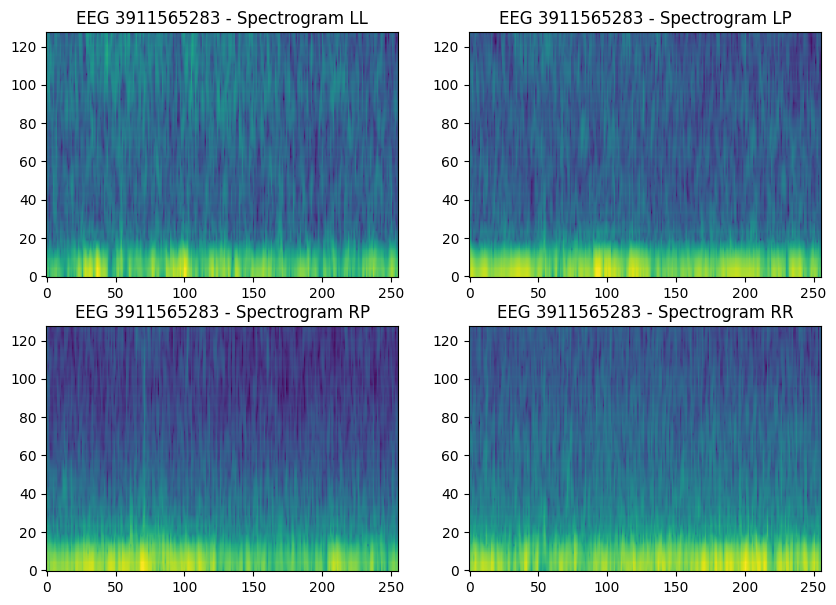

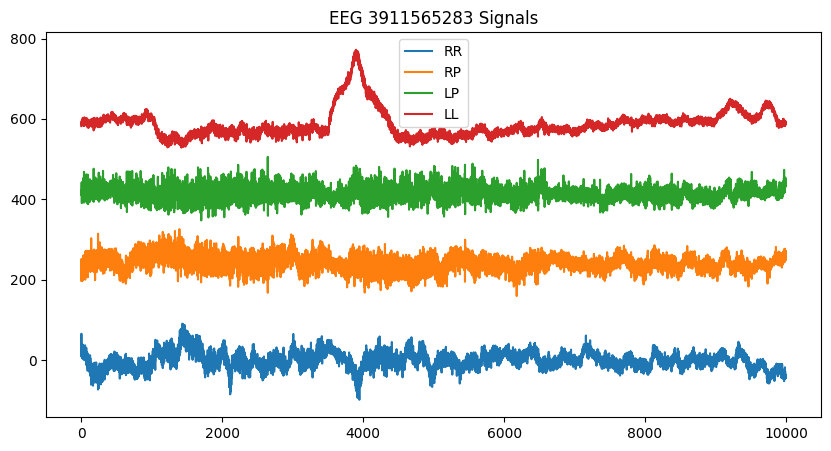


#########################



In [29]:

PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

In [30]:

preds = []
model = build_model()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test',
                         specs = spectrograms2, eeg_specs = all_eegs2)

for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'EffNet_v{VER}_f{i}.h5')
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 2s 2s/step
Fold 2
1/1 [==============================] - 0s 46ms/step
Fold 3
1/1 [==============================] - 0s 45ms/step
Fold 4
1/1 [==============================] - 0s 44ms/step
Fold 5
1/1 [==============================] - 0s 43ms/step

Test preds shape (1, 6)


In [31]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.25999,0.066723,0.014095,0.077608,0.115279,0.466304


In [32]:
# check if distribution sums ~ 1
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32